# **肥満リスクの多クラス予測**
(Multi-Class Prediction of Obesity Risk)

# 参考資料
**書籍**


**Kaggle**
- [easy peasy EDA & XGBoost is all you need](https://www.kaggle.com/code/lucamassaron/easy-peasy-eda-xgboost-is-all-you-need)

**自分で作成したファイル**
- 銀行解約データセットを使用した二項分類
- Home_Credit_Default_Risk
- 肝硬変の転帰の多クラス予測
- 馬の健康への影響を予測する
- ルワンダにおける CO2 排出量を予測する

**その他**


## ライブラリ・データセットのインポート

In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from lightgbm import LGBMClassifier # 特徴量の重要度評価で用いる

## 実行時間を調べるために使う

In [3]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [4]:
FILE_PATH = '/kaggle/input/playground-series-s4e2/'
OUTPUT_DIR = '/kaggle/working/'

train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

train_id = train['id']
train.drop('id', axis=1, inplace=True)

test_id = test['id']
test.drop('id', axis=1, inplace=True)

target = train['NObeyesdad']
target_col = 'NObeyesdad'

target_name = str(train.iloc[:, [-1]].columns.tolist()) # カラム数-2の値が目的変数

df = pd.concat([train, test], axis=0)
df.reset_index(inplace=True)

# 説明変数をデータ型ごとに代入する
numerical_features = df._get_numeric_data().columns
categorical_features = df.drop(numerical_features, axis=1).columns

categorical_features = df.drop(target_col, axis=1).columns

## 前処理

### 欠損値の補完

In [5]:
def missing_values(df):

    return df

### 外れ値の修正

In [6]:
def outlier(df):

    return df

### スケーリング（標準化）

- MinMaxScaler(正規化)

In [7]:
def scaling_MinMaxScaler(df, scale_cols):
    df_scale = df[scale_cols]
    sc = MinMaxScaler()
    df[scale_cols] = pd.DataFrame(sc.fit_transform(df_scale), columns = df_scale.columns)

    return df

## 特徴量エンジニアリング

### 特徴量の作成

In [8]:
def create_new_features(df):
    # BMI
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)
    
    # 身体のアクティビティレベル
    df['Physical_Activity_Level'] = df['FAF'] - df['TUE']
    
    # 食習慣
    df['Meal_Habits'] = df['FCVC'] * df['NCP']
    
    # 健康栄養習慣
#     df['Healthy_Nutrition_Habits'] = df['FCVC'] / (2 * df['FAVC_no'] - 1)
    
    # 技術使用法スコア
    df['Tech_Usage_Score'] = df['TUE'] / df['Age']
    
    return df

#### ビンニング

In [9]:
def binning(df):
    
    return df

### カテゴリ変数のエンコーディング

* One-HotEncoding

In [10]:
def one_hot_encoding(df, cat_cols):
    df[target_col] = df[target_col].map({
    "Insufficient_Weight":0,
    "Normal_Weight":1,
    "Obesity_Type_I":2,
    "Obesity_Type_II":3,
    "Obesity_Type_III":4,
    "Overweight_Level_I":5,
    "Overweight_Level_II":6,
    })

    df = pd.get_dummies(df, columns=cat_cols)

    return df

- LabelEncoding

In [11]:
def label_encoder(df, categorical_columns):
#     categorical_columns = df.select_dtypes(include=['object']).columns

    for column in categorical_columns:
        df[column] = df[column].fillna('').astype('str') # 欠損値の補完をする
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])

    return df

- pd.get_dummies

In [12]:
def get_dummies(df, cat_cols):
    df = pd.get_dummies(df, columns=cat_cols)
    
    return df

### 特徴量の選択

#### 特徴量の重要度評価

In [13]:
def feature_importance_evaluation(df):
    # 訓練データをX(説明変数)とy（目的変数）に分割する
    X = df.select_dtypes(include=['float', 'int'])
#     X = X.drop([target_col], axis=1) # 目的変数を指定する
    y = target # 目的変数を指定する

    

    # 特徴量の重要度評価
    clf = LGBMClassifier(
        random_state=42,
    )

    clf.fit(X, y)
    importance = clf.feature_importances_

    feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
        .sort_values(ascending=True, by='importance')

    return feature_importance

#### 特徴量の削除

In [14]:
def drop_columns(df):
    drop_list = [
        
    ]
    dropped_df = df.drop(columns=drop_list)

    return dropped_df

### データセットの更新

In [15]:
# 前処理
df = missing_values(df)
df = outlier(df)

scale_cols = []
# df = scaling_MinMaxScaler(df, scale_cols) # 標準化したい時のみ実行する

# 特徴量エンジニアリング
df = create_new_features(df)
df = binning(df)
df = missing_values(df)
df = drop_columns(df)

ohe_cols = [] # One-Hot Encodingしたい水準数の少ないカラムを指定する
dummies_cols = [] # pd.get_dummiesしたい水準数の少ないカラムを指定する
df = one_hot_encoding(df, ohe_cols)
df = get_dummies(df, dummies_cols)
df = label_encoder(df, categorical_features)

In [16]:
train = df[:20758]
test = df[20758:]

# train_x = train.drop(columns=[target_col])
# train_y = target
# test_x = test.drop(columns=[target_col])

train_x = train
train_y = target
test_x = test

X = train_x.values
y = train_y.values
# y = y.astype(int)

df.head()

,index,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Physical_Activity_Level,Meal_Habits,Tech_Usage_Score
0,0,1,1095,933,1839,1,1,265,589,2,0,1491,0,0,1053,2,3,6.00000,28.25956,-0.97647,5.96659,0.03995
1,1,0,108,128,1376,1,1,265,624,1,0,756,0,751,1068,3,0,1.00000,23.42209,0.00000,6.00000,0.05556
2,11112,0,108,1040,1253,1,1,206,127,2,0,659,0,587,1322,3,3,0.00000,17.12671,-0.80754,2.65472,0.09298
3,12981,0,522,1035,936,1,1,1053,624,2,0,464,0,1040,806,2,3,4.00000,44.85580,0.68766,9.00000,0.03724
4,14092,1,1605,2050,2205,1,1,735,252,2,0,727,0,1330,995,2,3,6.00000,25.59915,1.03625,5.28288,0.02945


In [17]:
# 特徴量の重要度評価
train_importance = train
feature_importance = feature_importance_evaluation(train_importance)
feature_importance

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3328
[LightGBM] [Info] Number of data points in the train set: 20758, number of used features: 22
[LightGBM] [Info] Start training from score -2.107483
[LightGBM] [Info] Start training from score -1.907353
[LightGBM] [Info] Start training from score -1.964779
[LightGBM] [Info] Start training from score -1.854892
[LightGBM] [Info] Start training from score -1.635203
[LightGBM] [Info] Start training from score -2.146276
[LightGBM] [Info] Start training from score -2.107879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

,importance
SCC,0
family_history_with_overweight,4
MTRANS,6
FAVC,17
SMOKE,23
CAEC,24
CALC,80
Tech_Usage_Score,121
TUE,201
NCP,258


<Axes: >

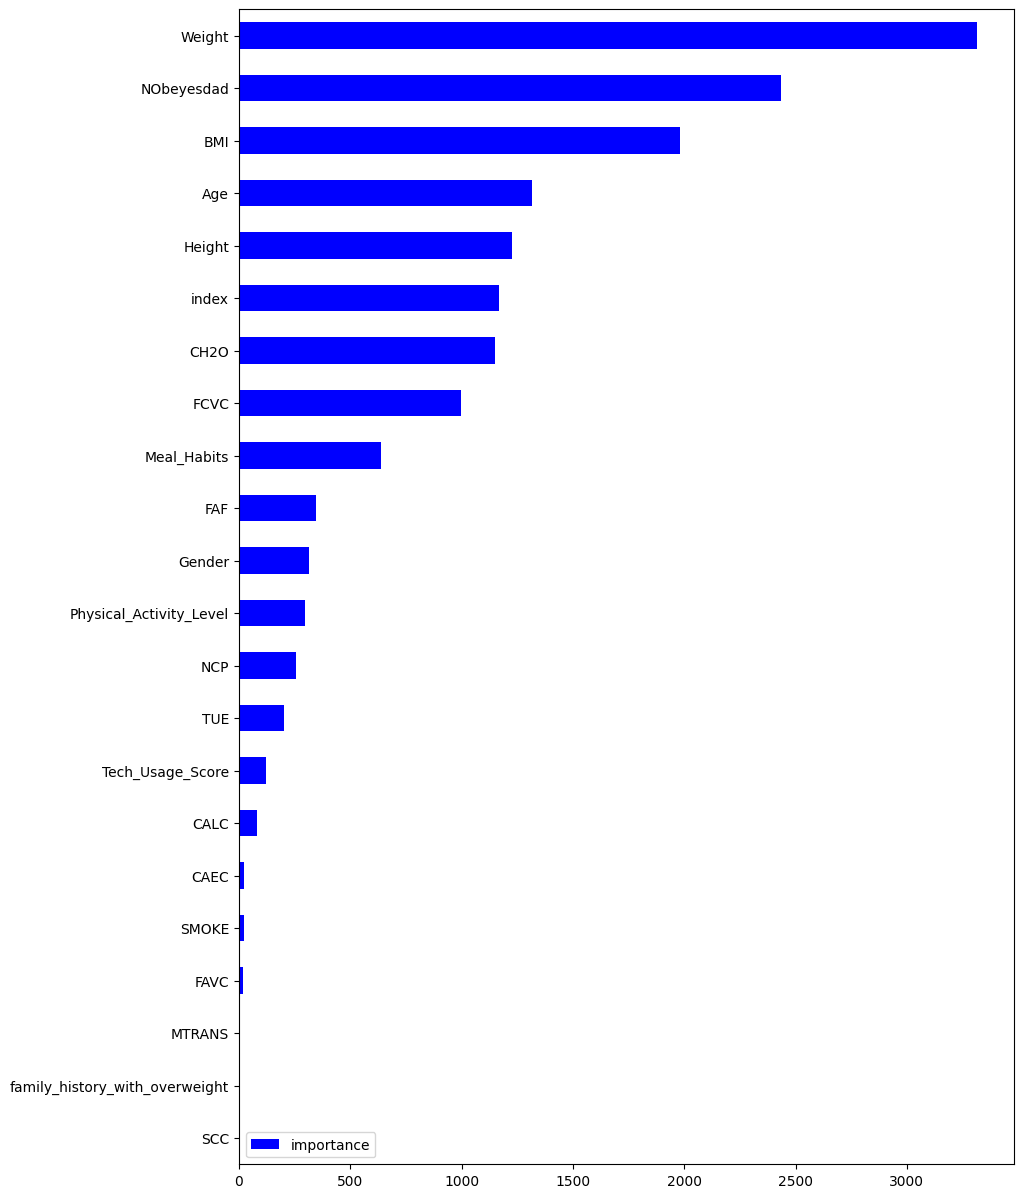

In [18]:
feature_importance.plot(kind='barh', figsize=(10, 15), color='b')

In [19]:
df.to_csv(OUTPUT_DIR + 'data.csv', index=False)

In [20]:
def file_to_xy(filename):
    data = pd.read_csv(filename, index_col=0)
    print(f'読み込み完了 {filename}')
    train = data[:20758].reset_index(drop=True)
    test = data[20758:].reset_index(drop=True).drop(target_col, axis=1) # 目的変数を指定する
    # 目的変数と説明変数に分割
    X = train.drop([target_col], axis=1) # 目的変数を指定する
    y = train[target_col].values # 目的変数を指定する

    return data,test,train,X,y

In [21]:
filename = 'data.csv'
data,test,train,X,y = file_to_xy(OUTPUT_DIR + filename)

読み込み完了 /kaggle/working/data.csv


In [22]:
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI,Physical_Activity_Level,Meal_Habits,Tech_Usage_Score
index,,,,,,,,,,,,,,,,,,,,,
0,1,1095,933,1839,1,1,265,589,2,0,1491,0,0,1053,2,3,6.00000,28.25956,-0.97647,5.96659,0.03995
1,0,108,128,1376,1,1,265,624,1,0,756,0,751,1068,3,0,1.00000,23.42209,0.00000,6.00000,0.05556
11112,0,108,1040,1253,1,1,206,127,2,0,659,0,587,1322,3,3,0.00000,17.12671,-0.80754,2.65472,0.09298
12981,0,522,1035,936,1,1,1053,624,2,0,464,0,1040,806,2,3,4.00000,44.85580,0.68766,9.00000,0.03724
14092,1,1605,2050,2205,1,1,735,252,2,0,727,0,1330,995,2,3,6.00000,25.59915,1.03625,5.28288,0.02945
